---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 6

---

Please write your full name here
- **Name** : "tark salah"

## Using GPU

Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'DL/assignments/assignment3/'
FOLDERNAME = 'DL_6'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))



In [ ]:
# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/MyDrive/$FOLDERNAME/datasets/
# !bash get_datasets.sh
%cd /content/drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/DL_6


# Generative Adversarial Networks (GANs)

In this notebook, we will build **generative models** using neural networks. 
### What is a GAN?

As we covered in the lectures, a GAN's goal is for the generator ($G$) to fool the discriminator ($D$) and the discriminator to correctly classify real vs. fake in a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. 

To optimize this minimax game, we aternate between training $G$ and $D$:

1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Here's an example of what your outputs from the 3 different models you're going to train should look like. Note that GANs are sometimes finicky, so your outputs might not look exactly like this. This is just meant to be a *rough* guideline of the kind of quality you can expect:

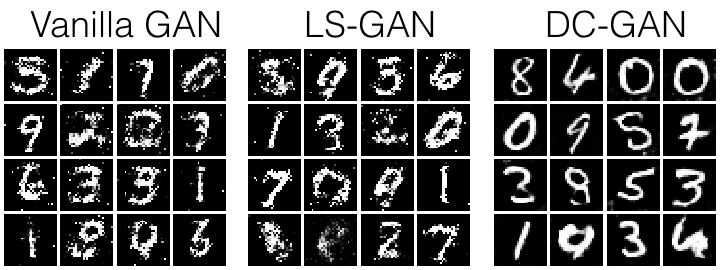

In [ ]:
# Run this cell to see sample outputs.
from IPython.display import Image
Image('images/gan_outputs_tf.png')

## Setup

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

from dl.gan_tf import preprocess_img, deprocess_img, rel_error, count_params, MNIST
NOISE_DIM = 96

In [ ]:
# Colab users only
%cd drive/MyDrive/$FOLDERNAME/
%cp -r gan-checks-tf.npz /content/
%cd /content/

[Errno 2] No such file or directory: 'drive/MyDrive/DL_6/'
/content/drive/MyDrive/DL_6
/content


In [ ]:
answers = np.load('gan-checks-tf.npz')

## Dataset
We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

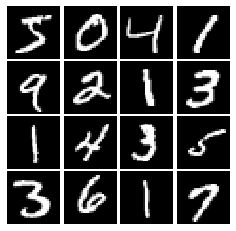

In [ ]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. LeakyReLUs keep ReLU units from dying and are often used in GAN methods.

HINT: You should be able to use `tf.maximum` and alpha parameter for leaky part of ReLU



REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![image](https://drive.google.com/uc?id=1s57YMDq-1hgkhF-kjRPu0zjxhSuaHQOp)  |  ![image](https://drive.google.com/uc?id=1G-sMuudxnq0fWDarCYZMccJIhQgGTmoy)


In [ ]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(alpha *x, x)
    #pass

Test your leaky ReLU implementation. You should get errors < 1e-10

In [ ]:
def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [ ]:
def sample_noise(batch_size, dim, seed=None):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    if seed is not None:
      tf.random.set_seed(seed)
    # TODO: sample and return noise
    return tf.random.uniform(shape=[batch_size,dim], minval=-1, maxval=1)
    # pass

Make sure noise is the correct shape and type:

In [ ]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. **Hint:** You should use the layers in `tf.keras.layers` to build the model.
All fully connected layers should include bias terms. 

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.



In [ ]:
def discriminator(seed=None):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    if seed is not None:
        tf.random.set_seed(seed)
        
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(784),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(0.01),
    tf.keras.layers.Dense(1)
    ])
    return model

In [ ]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.keras.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])
 

In [ ]:
def generator(noise_dim=NOISE_DIM, seed=None):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """

    if seed is not None:
        tf.random.set_seed(seed)
    model = None
    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: tf.keras.models.Sequential might be helpful.                         #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(noise_dim),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(784,activation = tf.nn.tanh)
    ])
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return model

Test to make sure the number of parameters in the generator is correct:

In [ ]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/ones) and [tf.zeros](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/zeros) to generate labels for your discriminator. Use [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses/BinaryCrossentropy) to help compute your loss function.

Don't use averaging by batch size

## Discriminator Loss

In [ ]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
    fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
    loss = real_loss + fake_loss
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss


## Generator Loss

In [ ]:
def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-8.

In [ ]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [ ]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `Adam` optimizer with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 


In [ ]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    # TODO: create an AdamOptimizer for D_solver and G_solver
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    D_solver = tf.optimizers.Adam(learning_rate,beta1)
    G_solver = tf.optimizers.Adam(learning_rate,beta1)
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

**If you are a Colab user, it is recommeded to change colab runtime to GPU.**

#### Train your GAN! This should take about 10 minutes on a CPU, or about 2 minutes on GPU.

Implement the training like we did in the tutorials

In [ ]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=250, print_every=20, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    images = []
    for epoch in range(num_epochs):
        for (x, _) in mnist:

          # Train discriminator
            with tf.GradientTape() as tape:
                real_data = x
                #print("img:", x.shape)
                logits_real = D(preprocess_img(real_data))

                ######START YOUR CODE HERE##########
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
                ######END YOUR CODE HERE##########


          # Train generator
            with tf.GradientTape() as tape:
                
                ######START YOUR CODE HERE##########
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))
                ######END YOUR CODE HERE##########

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = tf.identity(fake_images).numpy()
                images.append(imgs_numpy[0:16])
                
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    
    return images, G_sample[:16]


In [ ]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

Epoch: 0, Iter: 0, D: 1.177, G:0.7283
Epoch: 0, Iter: 250, D: 1.829, G:0.8172
Epoch: 1, Iter: 500, D: 1.649, G:0.9253
Epoch: 1, Iter: 750, D: 1.364, G:1.665
Epoch: 2, Iter: 1000, D: 1.211, G:0.8859
Epoch: 2, Iter: 1250, D: 1.228, G:1.281
Epoch: 3, Iter: 1500, D: 1.252, G:0.5755
Epoch: 3, Iter: 1750, D: 1.328, G:0.8124
Epoch: 4, Iter: 2000, D: 1.162, G:0.9587
Epoch: 4, Iter: 2250, D: 1.301, G:0.8056
Epoch: 5, Iter: 2500, D: 1.249, G:0.9063
Epoch: 5, Iter: 2750, D: 1.405, G:0.6959
Epoch: 6, Iter: 3000, D: 1.331, G:0.8239
Epoch: 6, Iter: 3250, D: 1.378, G:0.7596
Epoch: 7, Iter: 3500, D: 1.215, G:0.5899
Epoch: 7, Iter: 3750, D: 1.293, G:0.8753
Epoch: 8, Iter: 4000, D: 1.327, G:0.8864
Epoch: 9, Iter: 4250, D: 1.273, G:0.7968
Epoch: 9, Iter: 4500, D: 1.397, G:0.7825


Iter: 0


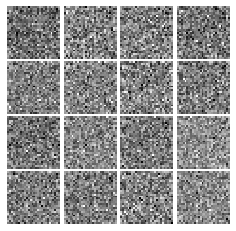


Iter: 20


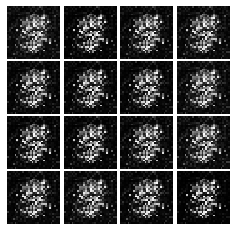


Iter: 40


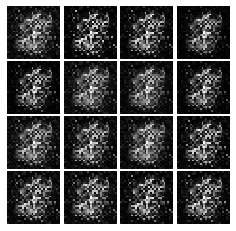


Iter: 60


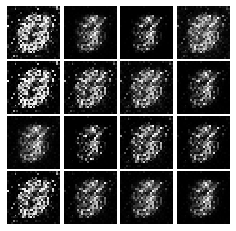


Iter: 80


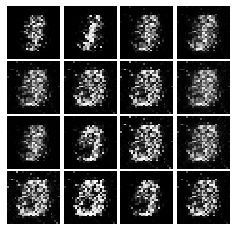


Iter: 100


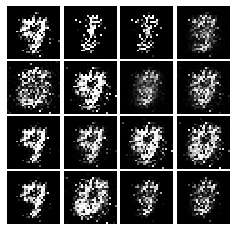


Iter: 120


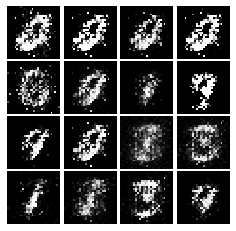


Iter: 140


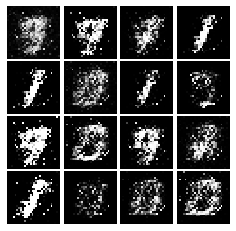


Iter: 160


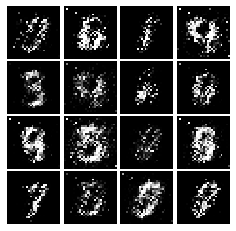


Iter: 180


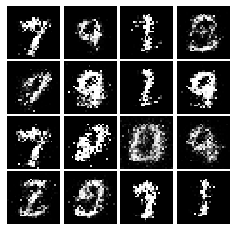


Iter: 200


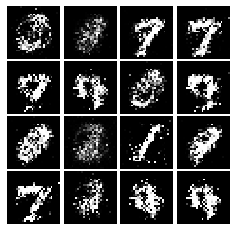


Iter: 220


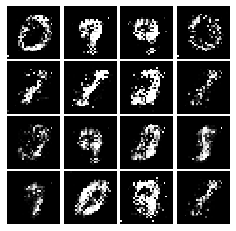


Iter: 240


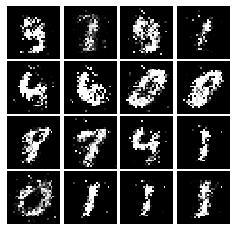


Iter: 260


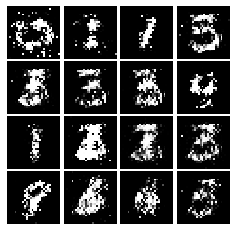


Iter: 280


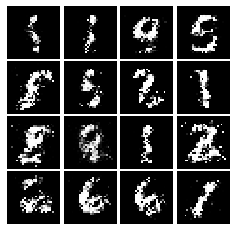


Iter: 300


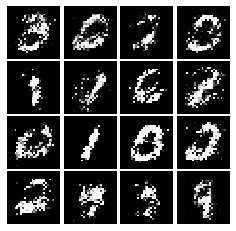


Iter: 320


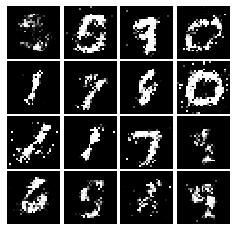


Iter: 340


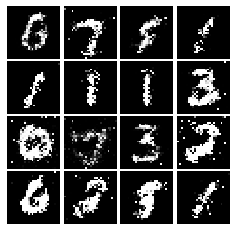


Iter: 360


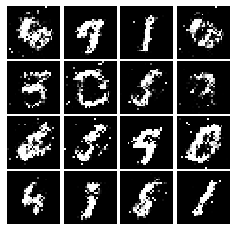

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).


In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: Tensor of shape (N, 1) giving scores for the real data.
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5*tf.reduce_mean(tf.square(scores_real - 1)) + 0.5*tf.reduce_mean(tf.square(scores_fake))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

In [ ]:
def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0.5*tf.reduce_mean((tf.square(scores_fake-1)))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss


Test your LSGAN loss. You should see errors less than 1e-8.

In [ ]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    
    d_loss = ls_discriminator_loss(tf.constant(score_real), tf.constant(score_fake))
    g_loss = ls_generator_loss(tf.constant(score_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [ ]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss)

Epoch: 0, Iter: 0, D: 2.792, G:0.5677
Epoch: 0, Iter: 250, D: 0.1176, G:0.46
Epoch: 1, Iter: 500, D: 0.2726, G:0.8355
Epoch: 1, Iter: 750, D: 0.4253, G:0.5402
Epoch: 2, Iter: 1000, D: 0.1192, G:1.309
Epoch: 2, Iter: 1250, D: 0.1132, G:0.3933
Epoch: 3, Iter: 1500, D: 0.1631, G:0.3037
Epoch: 3, Iter: 1750, D: 0.1956, G:0.2204
Epoch: 4, Iter: 2000, D: 0.1826, G:0.2468
Epoch: 4, Iter: 2250, D: 0.2057, G:0.2451
Epoch: 5, Iter: 2500, D: 0.2009, G:0.2214
Epoch: 5, Iter: 2750, D: 0.2289, G:0.1658
Epoch: 6, Iter: 3000, D: 0.2444, G:0.1693
Epoch: 6, Iter: 3250, D: 0.2254, G:0.1669
Epoch: 7, Iter: 3500, D: 0.2462, G:0.181
Epoch: 7, Iter: 3750, D: 0.192, G:0.2018
Epoch: 8, Iter: 4000, D: 0.2179, G:0.1662
Epoch: 9, Iter: 4250, D: 0.2455, G:0.1486
Epoch: 9, Iter: 4500, D: 0.2509, G:0.1713


Iter: 0


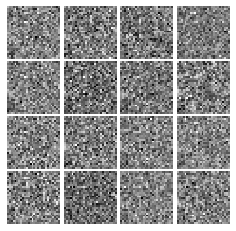


Iter: 20


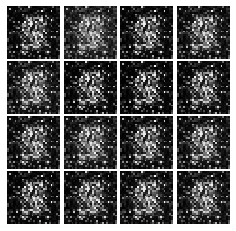


Iter: 40


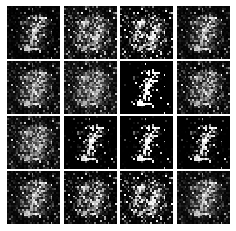


Iter: 60


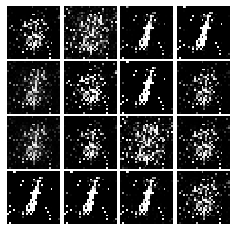


Iter: 80


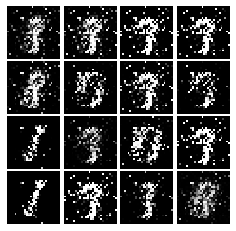


Iter: 100


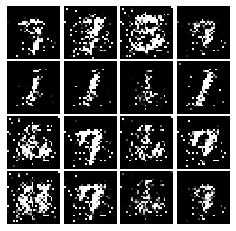


Iter: 120


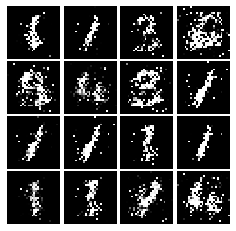


Iter: 140


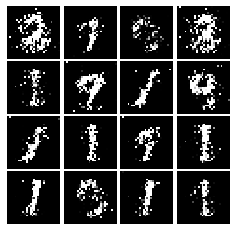


Iter: 160


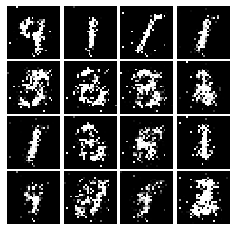


Iter: 180


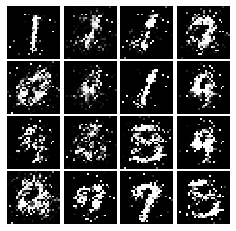


Iter: 200


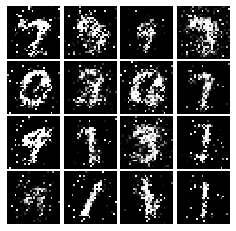


Iter: 220


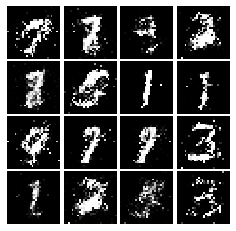


Iter: 240


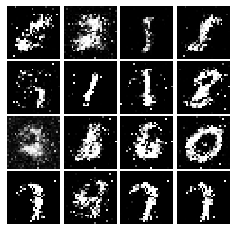


Iter: 260


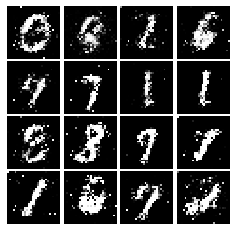


Iter: 280


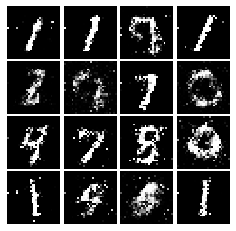


Iter: 300


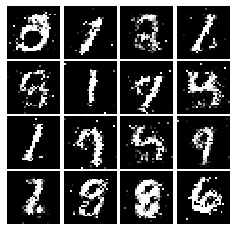


Iter: 320


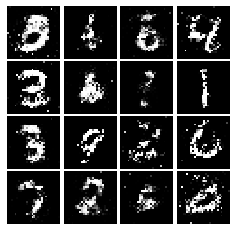


Iter: 340


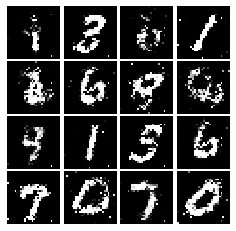


Iter: 360


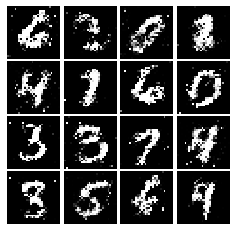

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()
    


# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.keras.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.


In [ ]:
def dc_discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = None
    ##############################################################################
    # TODO: Implement architecture                                               #
    #                                                                            #
    # HINT: tf.keras.models.Sequential might be helpful.                         #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(784),
      tf.keras.layers.Reshape((28,28,1)),
      tf.keras.layers.Conv2D(32,(5,5),strides = 1,padding = 'VALID'),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.MaxPool2D((2,2),strides = 2),
      tf.keras.layers.Conv2D(64,(5,5),strides = 1,padding = 'VALID'),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.MaxPool2D((2,2),strides = 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(4*4*64),
      tf.keras.layers.LeakyReLU(0.01),
      tf.keras.layers.Dense(1)
    ])

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return model

Test your discriminator

In [ ]:
def test_discriminator(true_count=1102721):
    model = dc_discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
test_discriminator()

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.keras.layers` for your implementation. You might find the documentation for [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.


In [ ]:
def dc_generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential()
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(noise_dim),
    tf.keras.layers.Dense(1024,activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7*7*128,activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape((7,7,128)),
    tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(4,4),strides = 2,activation = tf.nn.relu,padding = 'SAME'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=(4,4),strides = 2,activation = tf.tanh,padding = 'SAME')
    ])

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model

Testing



In [ ]:
def test_generator(true_count=6595521):
    model = dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
test_generator()

Correct number of parameters in discriminator.


We have to recreate our network since we've changed our functions.
### Train and evaluate a DCGAN
This is the one part of assignment that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).


In [ ]:
# Make the discriminator
D = dc_discriminator()

# Make the generator
G = dc_generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
images, final = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs=5)

Epoch: 0, Iter: 0, D: 1.513, G:0.6675
Epoch: 0, Iter: 250, D: 0.8527, G:2.376
Epoch: 1, Iter: 500, D: 0.394, G:5.048
Epoch: 1, Iter: 750, D: 0.2598, G:5.522
Epoch: 2, Iter: 1000, D: 0.3954, G:2.961
Epoch: 2, Iter: 1250, D: 0.2891, G:4.057
Epoch: 3, Iter: 1500, D: 0.3424, G:4.075
Epoch: 3, Iter: 1750, D: 0.5637, G:4.604
Epoch: 4, Iter: 2000, D: 0.9833, G:1.001
Epoch: 4, Iter: 2250, D: 0.5945, G:1.639


Iter: 0


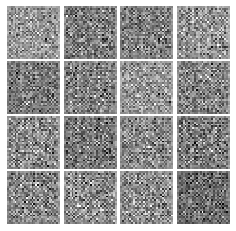


Iter: 20


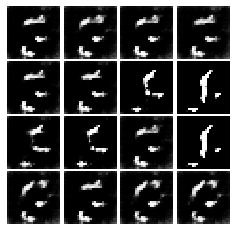


Iter: 40


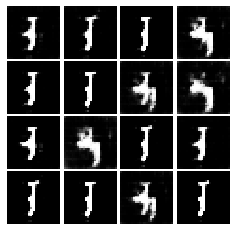


Iter: 60


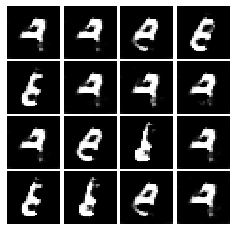


Iter: 80


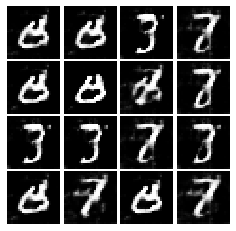


Iter: 100


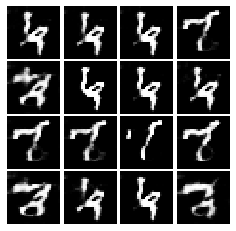


Iter: 120


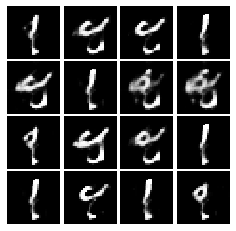


Iter: 140


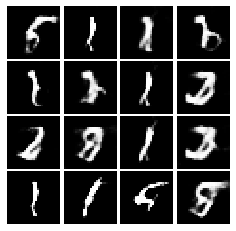


Iter: 160


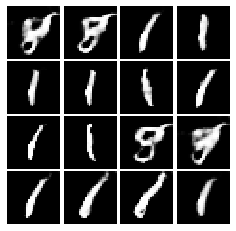


Iter: 180


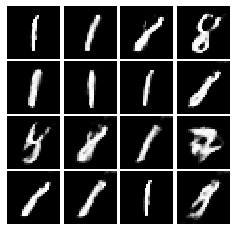

In [ ]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 20
    print()

## QUESTION 1
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient.

### Your answer: no it's not, as the generator will become strong at deceiving the discriminator, so the discriminator will be easily deceived of fake images from generator, and the decline in generator loss is also likely to be due to the fact that the discriminator is too poor to be easily deceived.


## QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

### Your Answer: DCGAN generator images is less noisy